In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

In [23]:
# Import the excel spreadsheets in the data folder
installer_df = pd.read_excel('../data/Installer.xlsx')
involver_df = pd.read_excel('../data/Involver.xlsx')

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [24]:
# Attempt to merge using a subset of key columns
merge_on_columns = ['Site', 'Vessel_Name', 'Wo_No']

df = pd.concat([installer_df, involver_df], axis=0)

# feature_columns = ['Object', 'Group', 'Symptom', 'Error_Cause', 'Cause_Details', 'Error_Class', 'Discovery', 'Completion_Note', 'Action_Taken', 'Work_Description', 'Directive']
feature_columns = ['Object', 'Group', 'Object_Type','Completion_Note', 'Work_Description', 'Directive']
# TODO: Change this to ESB1
target_column = 'EBS1'

# Filter the dataframe for the selected columns
df = df[feature_columns + [target_column]].dropna()

In [25]:
# Convert the target column to ids 
# Encode the target column
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column].astype(str))
df[target_column].dtype, df[target_column].unique()

(dtype('int64'),
 array([24,  2, 13,  5, 25, 12, 10,  4, 20,  8, 21, 28, 29,  9, 15, 17,  1,
         3, 18, 19, 26, 11,  0,  7, 22, 23, 14,  6, 27, 16]))

In [26]:
# Handling rare classes
class_counts = df[target_column].value_counts()
threshold = 2  # Minimum number of instances required
rare_classes = class_counts[class_counts < threshold].index.tolist()
df_filtered = df[~df[target_column].isin(rare_classes)]

# Split the data into training and testing sets
X = df_filtered[feature_columns]
y = df_filtered[target_column]

# Check if the length of X and y are consistent
assert len(X) == len(y), "Mismatch in the number of samples between X and y"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the TF-IDF vectorizer for text columns
preprocessor = ColumnTransformer(
    transformers=[
        (col, TfidfVectorizer(), col) for col in feature_columns
    ], remainder='drop'
)

params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 1200, 'solver': 'sgd', 'verbose': True}

# Create a pipeline with preprocessor, scaler, PCA, and MLPClassifier
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # Apply scaler after TF-IDF transformation
    ('pca', PCA(n_components=100)),  # Reduce to 100 principal components
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', MLPClassifier(**params))
])

# Fit the full pipeline
pipeline.fit(X_train, y_train)

Iteration 1, loss = 3.18784468
Iteration 2, loss = 3.06258272
Iteration 3, loss = 2.91513980
Iteration 4, loss = 2.77043023
Iteration 5, loss = 2.63224226
Iteration 6, loss = 2.50058122
Iteration 7, loss = 2.37537254
Iteration 8, loss = 2.25716300
Iteration 9, loss = 2.14442676
Iteration 10, loss = 2.03807581
Iteration 11, loss = 1.93798347
Iteration 12, loss = 1.84414812
Iteration 13, loss = 1.75618562
Iteration 14, loss = 1.67373911
Iteration 15, loss = 1.59599504
Iteration 16, loss = 1.52273787
Iteration 17, loss = 1.45440845
Iteration 18, loss = 1.39030871
Iteration 19, loss = 1.32989710
Iteration 20, loss = 1.27303068
Iteration 21, loss = 1.21978530
Iteration 22, loss = 1.16971891
Iteration 23, loss = 1.12281823
Iteration 24, loss = 1.07899762
Iteration 25, loss = 1.03755251
Iteration 26, loss = 0.99872663
Iteration 27, loss = 0.96192890
Iteration 28, loss = 0.92712676
Iteration 29, loss = 0.89430731
Iteration 30, loss = 0.86304571
Iteration 31, loss = 0.83385171
Iteration 32, los

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Object', TfidfVectorizer(),
                                                  'Object'),
                                                 ('Group', TfidfVectorizer(),
                                                  'Group'),
                                                 ('Object_Type',
                                                  TfidfVectorizer(),
                                                  'Object_Type'),
                                                 ('Completion_Note',
                                                  TfidfVectorizer(),
                                                  'Completion_Note'),
                                                 ('Work_Description',
                                                  TfidfVectorizer(),
                                                  'Work_Description'),
                                                 ('Directive',
                                                  TfidfVectorizer(),
                                                  'Directive')])),
                ('scaler', MaxAbsScaler()), ('pca', PCA(n_components=100)),
                ('sampler', RandomOverSampler(random_state=42)),
                ('classifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100),
                               learning_rate='adaptive', max_iter=1200,
                               solver='sgd', verbose=True))])

Test accuracy:  0.9090909090909091
Classification Report:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        22
           3       0.00      0.00      0.00         1
           4       0.60      1.00      0.75         3
           5       0.93      0.93      0.93        27
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
           9       0.75      1.00      0.86         3
          10       1.00      0.67      0.80         3
          12       1.00      0.50      0.67         2
          13       0.97      0.97      0.97        34
          17       0.00      0.00      0.00         2
          19       0.50      1.00      0.67         1
          20       1.00      1.00      1.00         3
          21       1.00      1.00      1.00         6
          22       0.60      1.00      0.75         3
          23       1.00      1.00      1.00         1
          25       1.00

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and b

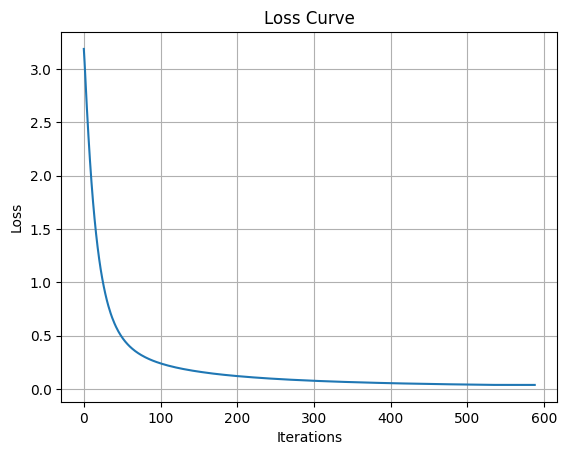

In [27]:
# Evaluate on the test set
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
classifier = pipeline.named_steps['classifier']
plt.plot(classifier.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()